### TK TK

TK TK 



---------

##### Necessary Packages

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import dask 
import datetime
import cftime

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

from IPython import display
display.set_matplotlib_formats('retina')

### Load in data


In [5]:
import os
from pathlib import Path
os.getcwd()

'/Users/miriam/Documents/02_Academia/02_PhD/research/projects/drought-termination/code'

In [6]:
# grab the default path
p = Path(os.getcwd())

# move up a directory
os.chdir(p.parent)

# save that location
project_prefix = os.getcwd()

In [7]:
region = 'US_Southwest'
variable_id = ['mrsos', 'pr', 'tas']
#variable_id = ['mrso', 'pr']

print_string = "-"

fn_prefix = '/savepoints/model_anoms/' + region + '_' + print_string.join(variable_id) + '_'

In [9]:
import re
import glob

# get filelist
fns = glob.glob(project_prefix + fn_prefix+ '*')

# get the 'key' that was used earlier - just using 
# regex to get the string after the last "_", which 
# is how to get the ks based on what i made the fn_prefix 

# above
ks = [re.split('\_',fn)[-1] for fn in fns]
# Load
dict_of_ds = dict()
for k in ks:
    dict_of_ds[k] = xr.open_dataset(project_prefix + fn_prefix+k)


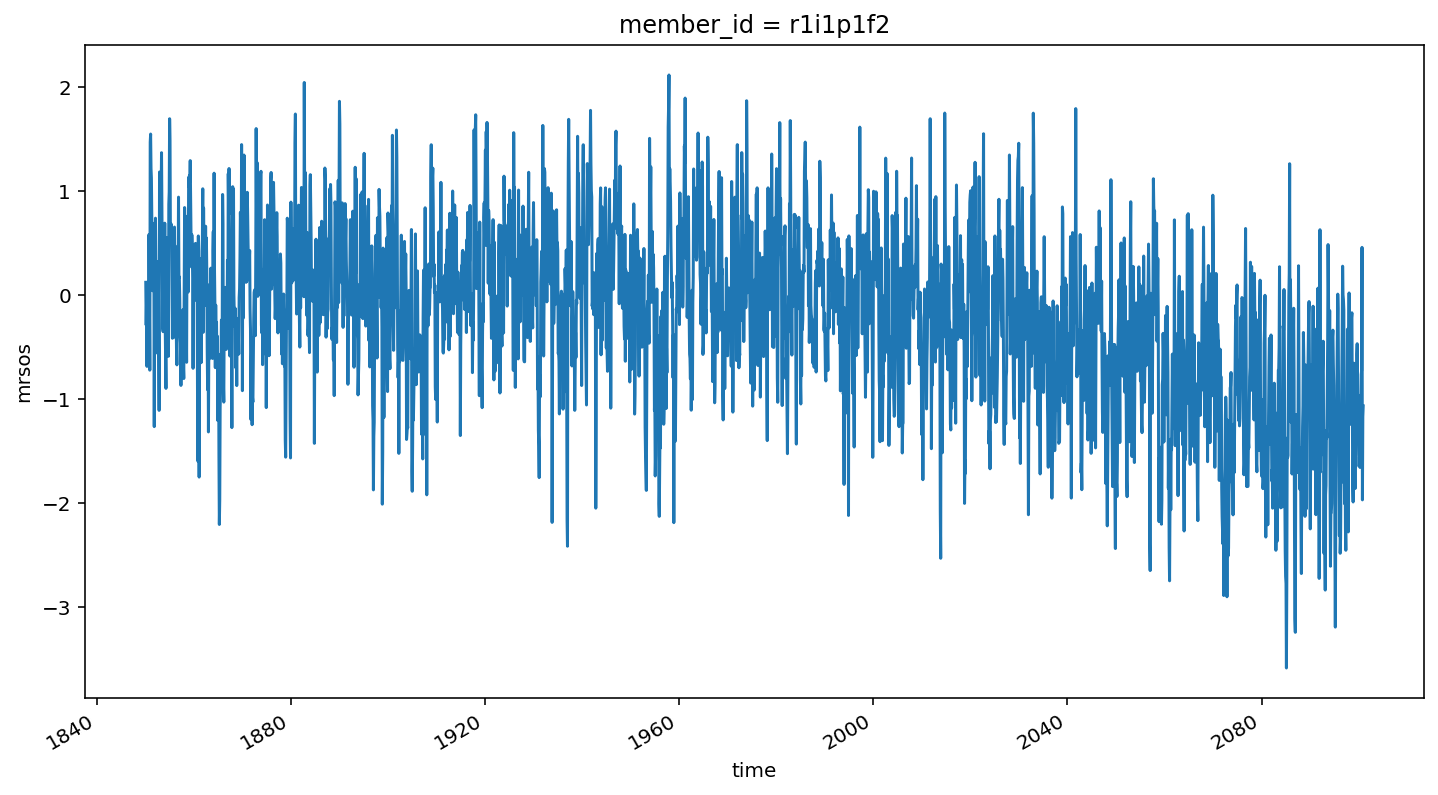

In [15]:
dict_of_ds['CNRM-ESM2-1'].sel(member_id ='r1i1p1f2').mrsos.plot()

In [16]:
model_anoms = dict_of_ds

In [19]:
models = model_anoms.keys()

## Drought Detection


------------
Calculate the rolling mean for each model

In [20]:
model_anoms_r = {model : {} for model in models}

for model in tqdm(model_anoms_r.keys()):
    #print('starting ' + model)
    
    # create the rolling average
    model_anoms_r[model] = model_anoms[model].rolling(time = 5, center = True).mean()
    #model_anoms_r[model] = model_anoms[model].rolling(time = 3, center = True).mean()
    

  0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
def find_drought_slices(td, tn):
    '''
    takes in lists of times when below threshold (td) and list of times when 
    above the mean (tn)
    recursively returns slices that span between drought initiation and termination (aka, a drought event)
    '''
    
    try:
        # drops months before first drought
        tn = [month for month in tn if (month > td[0])]

        first_slice = slice(td[0], tn[0])

        drought_slices = [first_slice]

        # drops months before first drought ends
        td = [month for month in td if (month > tn[0])]

        drought_slices.extend(find_drought_slices(td, tn))
        
        return drought_slices
    
    except:
        return []

def find_droughts(ds_r, ds, drought_threshold = -1):
    '''     
    finds droughts by defining drought as starting when the rolling mean drops below a given threshold  
    and ending when the soil moisture levels return to/exceed normal (0)
    '''
    
    # define a no longer in drought, or above drought threshold
    normal_or_above_times = ds.where(ds.mrsos.values >= 0).dropna(dim = 'time').time.values
    #normal_or_below = ds_r.where(ds_r.mrsos.values <= 0)
    in_drought_times = ds_r.where(ds_r.mrsos.values <= drought_threshold).dropna(dim = 'time').time.values
    
    return find_drought_slices(in_drought_times, normal_or_above_times)
    
def calc_sem(data):
    """standard error of mean = sample standard deviation / square root(sample size - 1)"""
    return np.std(data)/np.sqrt(len(data)-1.)

def SEA_composite(data, keyDates, months = range(-24,25)):
    """
    Create composites.
    Inputs:
        data = the data to composite from
        key_dates = a list of key dates in pandas datetime format.
        months = a range of integers (e.g. range(-12,13)). These integers
        will be subtracted from a base time in steps of months. If not
        specified it will default from -12 to 12.
    Outputs: A datarray with coordinates of relative months (as epoch), and
        with data variables of means, and standard error of means (sem).
    """
    composite = xr.Dataset(data_vars = None, 
                       coords = {'relative_month': range(-24,25)},
                       attrs=None)

    # temporary arrays of mean and standard error of mean 
    mn_tmp = []
    sem_tmp = []

    # loop through every month for the year preceeding and following 
    # the drought termination
    for n in months:
        # create an index of the date n months before/after drought termination
        index = [(date - datetime.timedelta(days = n * 30)) for date in keyDates]
        # append the average across all months n-away from drought termination into a temp means array
        mn_tmp.append((data.sel(time = index, method='nearest').mean()))
        # do the same but for standard error
        sem_tmp.append(calc_sem(data.sel(time = index, method='nearest')))

    # create xarray from temp mean and standard mean errors 
    composite = composite.assign({'means':  (['relative_month'], mn_tmp), 
                                  'standard_error_means': (['relative_month'], sem_tmp)})

    return composite


### Find drought events & drought terminations across all loaded models

In [23]:
# create dictionaries to hold drought events & terminations for each model and member id
droughts = {model : {} for model in models}
terminations = {model : {} for model in models}
starts = {model : {} for model in models}

# loop through all loaded models
for model in tqdm(model_anoms.keys()):
    droughts[model] = {member : {} for member in model_anoms[model].member_id.values}
    terminations[model] = {member : [] for member in model_anoms[model].member_id.values}
    starts[model] = {member : [] for member in model_anoms[model].member_id.values}
    
    # loop through each member_ids for the given model
    for member in model_anoms[model].member_id.values:
        droughts[model][member] = find_droughts(model_anoms_r[model].sel(member_id = member), model_anoms[model].sel(member_id = member))
        
        # find the drought terminations
        for drought in droughts[model][member]:
            terminations[model][member].append(drought.stop)
            starts[model][member].append(drought.start)

  0%|          | 0/16 [00:00<?, ?it/s]

Make sure the drought starts and terminations look okay

In [35]:
model_anoms['CNRM-CM6-1'].time[0]

<xarray.DataArray 'time' ()>
array('1850-01-16T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1850-01-16

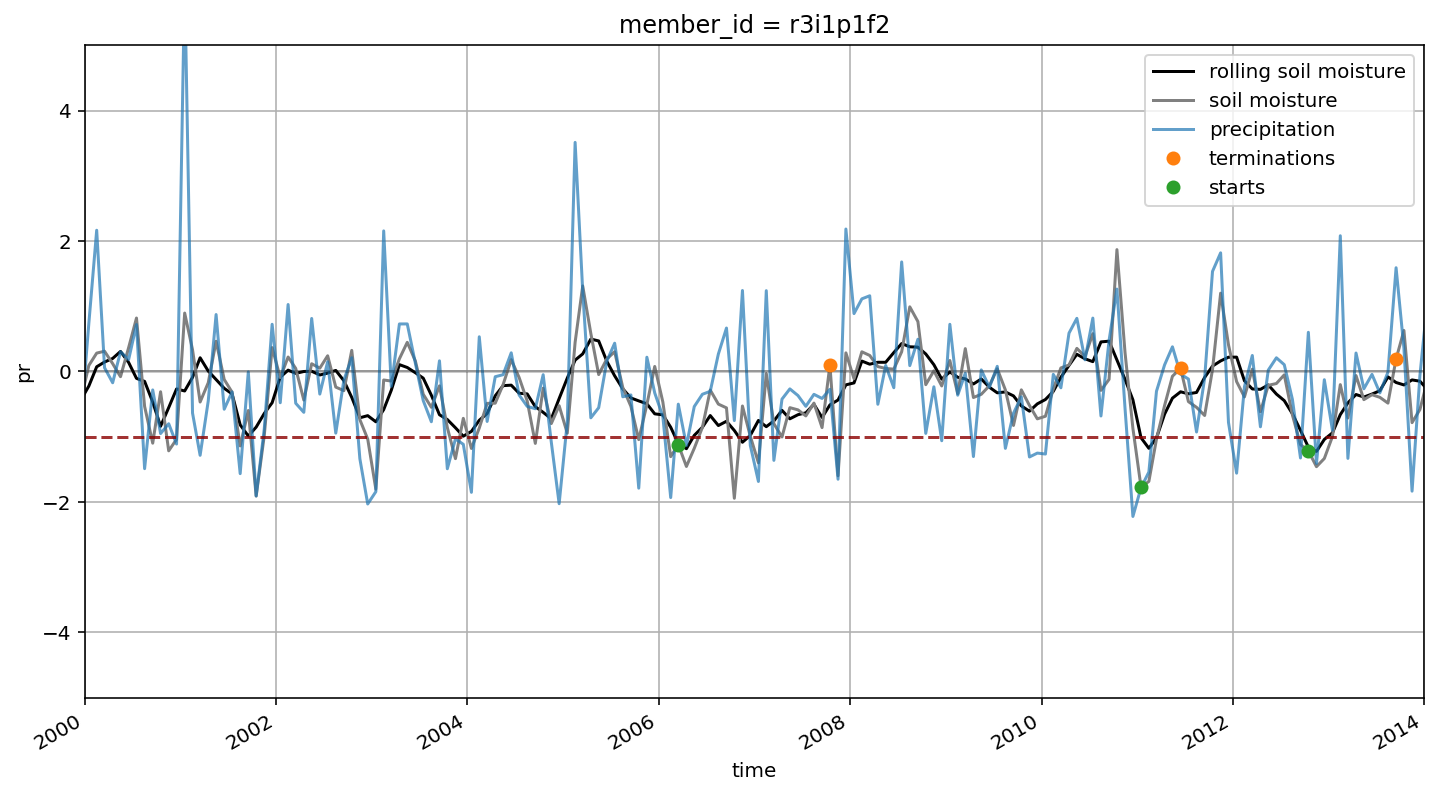

In [47]:
#plot_time_start = cftime.datetime(2000, 1, 16, 0, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=False)
#plot_time_end = cftime.datetime(2020, 12, 16, 0, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=False)

fig, ax = plt.subplots() 

model_anoms_r['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').mrsos.plot(label = 'rolling soil moisture', color = 'k')
model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').mrsos.plot(label = 'soil moisture', color = 'grey')
model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').pr.plot(label = 'precipitation', alpha = 0.7)

#ax.set_xlim(plot_time_start, plot_time_end)
ax.set_xlim('2000', '2014')

ax.axhline(0, alpha = 0.2, color = 'k')
ax.axhline(-1, alpha = 0.8, color = 'darkred', linestyle = '--')

ax.set_ylim(-5, 5)



#ax.plot(dates[drought_months],mrsos_rolling[drought_months],"o")
ax.plot(terminations['CNRM-CM6-1']['r3i1p1f2'], 
        model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').sel(time = terminations['CNRM-CM6-1']['r3i1p1f2'], method='nearest').mrsos, "o",  label = 'terminations')

ax.plot(starts['CNRM-CM6-1']['r3i1p1f2'], 
        model_anoms['CNRM-CM6-1'].sel(member_id = 'r3i1p1f2').sel(time = starts['CNRM-CM6-1']['r3i1p1f2'], method='nearest').mrsos, "o", label = 'starts')

ax.legend()

plt.grid()
